<img src='../00_common/figures/iaeaheader.svg' style='width:100%'/>
<p style="font-size:2em;padding-bottom: 0.5em; font-weight: bold;">
<em>E-learning course on <br / ><br / >
Advanced Neutron Imaging</em>
</p> 

# Measuring the attenuation coefficient of water using neutron imaging
## Solution
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2023

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

## Tutorial objectives

- Learning how to work with images in python.
- Understanding how the water content can be quantified from images.
    - Normalization
    - Correcting for scattering
    - Estimating the attenation coefficient of water (video demonstration).

### Loading some needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import pandas as pd
import skimage.morphology as morph
import sys

if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !rm -rf scripts
    !rm -rf QuantifyingNeutronImages
    !git clone https://github.com/ImagingELearning/QuantifyingNeutronImages.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/QuantifyingNeutronImages/tutorials/00_Common/data/"
    sys.path.append("/content/scripts/python")
else: 
    # Running locally on your computer
    data_path = "../00_Common/data/"

import sys
sys.path.append('../00_Common/')
import amglib.bb as bb

## Working with images
In this section you will be given some useful image operations that you'll need during the tutorial.

### Load and inspect images
In this tutorial, we will work with tiff images. These are best read using the ```tifffile``` package. 

In [2]:
img=tiff.imread(data_path+'stepwedge/exp10s_h2o.tif')

The ```imread``` can read single and multi-frame tiff images. Multi-frame are either volumes or time-series of 2D-images.

The loaded image is essentially a large 2D or 3D matrix and inspecting the individual number does rarely make sense. Therefore, we need a way to display the images. This is provided by the package ```matplotlib.pyplot```:

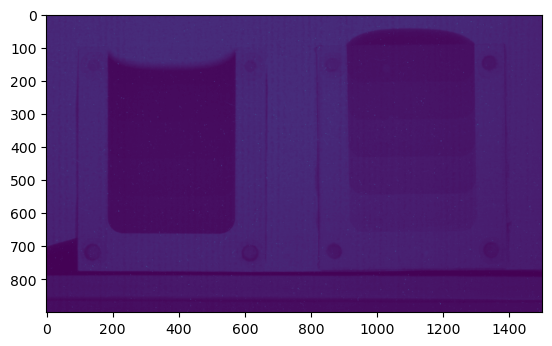

In [3]:
plt.imshow(img);

This image has some outliers and the relevant information is too dark. This can be adjusted using ```vmin``` and ```vmax```.

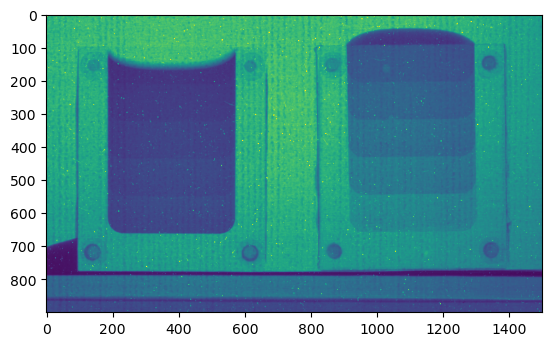

In [4]:
plt.imshow(img,vmin=300, vmax=4000);

We should also add some decorations like axis labels, title and colorbar to the image.

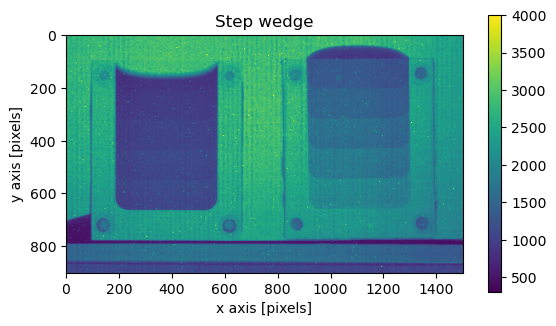

In [5]:
plt.imshow(img,vmin=300, vmax=4000);
plt.colorbar(shrink=0.75)
plt.title('Step wedge')
plt.xlabel('x axis [pixels]')
plt.ylabel('y axis [pixels]');

We may not want to work with both wedges at the same time. Then we can crop using array slicing. The intervals are give with the colon separator e.g. here 750:1450 means we use the columns in this interval. Note also that the rows are specified with a single colon. This means we use all rows.

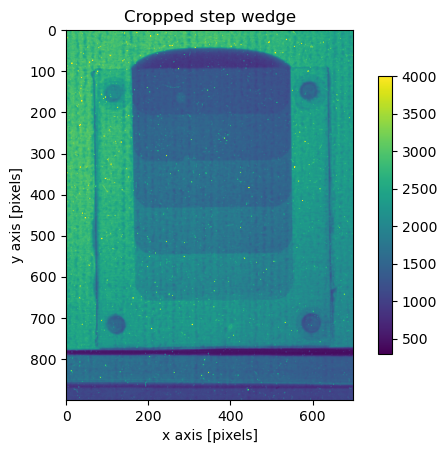

In [6]:
plt.imshow(img[:,750:1450],vmin=300, vmax=4000);
plt.colorbar(shrink=0.75)
plt.title('Cropped step wedge')
plt.xlabel('x axis [pixels]')
plt.ylabel('y axis [pixels]');

### Image calculations
The images are often manipulated pixelwise the arithmetic operations are applied for each pixel in the image individually. This can be done with two images with the same shape or with constants

```python
c=a+b
d=3.14*c
f=(c-a)/b
```

With the numpy package you can also apply many functions 
```python
c=np.log(b)
a=np.sin(x)
```

### Working on selected pixels
Sometimes it is needed to adjust a selection of pixels to avoid bad calculations like division by zero etc.

```python
a[a<1]=1
```
finds all pixels with values less than one and replaces them by one.

## Determining the attenuation coefficient of water
Neutrons are very sensitive to hydrogen. This fact is often used in neutron imaging to measure the local water content in a sample. The thickness of water behind each pixel can be determined using Beer-Lambert's law

$$I_{wet}=I_0 e^{-\int_L \mu(x)dx}$$

which simplifies to 

$$I=I_0 e^{-\left(l_{H_2O}\cdot\mu_{H_2O}+l_{sand}\cdot\mu_{sand}+l_{container}\cdot\mu_{container}\right)}$$

<img src="figures/porous_media_sand.svg" style="height:200px" />

The terms for _sand_ and _container_ can be removed with help of reference images, which leaves us with the term for water $l_{H_2O}\cdot\mu_{H_2O}$. Here, $l_{H_2O}$ is the thinkness of water which is the information we want to know and $\mu_{H_2O}$ is the attenuation coefficient of water. Now, this measurement provides more information than we actually need. Therefore, we need a reference meassurement if the container with dry sand. 

$$I_{dry}=I_0 e^{-\left(l_{sand}\cdot\mu_{sand}+l_{container}\cdot\mu_{container}\right)}$$

Dividing $I_{wet}$ by $I_{dry}$ like

$$T_{H_2O}=\frac{I_{wet}}{I_{dry}}=e^{-l_{H_2O}\cdot\mu_{H_2O}}$$

Gives us the transmission contribution of water. This result still doesn't tell us the water thickness. For that, we need to know the attenuation coefficient of water $\mu_{H_2O}$ which we will estimate in the first exercise.

### Using a step wedge
A step wedge is a wedge shaped device with step wise increasing material thickness. This allows to determine the attenuation coefficient for different thicknesses and thereby increasing the accuracy of the estimate compared to measuring for a single thickness.  

<img src="figures/step_wedge.svg" style="height:300px"/>

A step wedge for liquids is a container in which you pour the liquid. It is best to use a container with constant wall thickness to reduce the uncertainty of changing amounts of material besides the liqiud itself. The wedges used in this experiment have the steps
0.5, 1.0, 1.5, 2.0, 2.5 mm for the thinner wedge and 3.0, 3.5, 4.0, 4.5, 5.0 mm for the thicker wedge.

For this task you'll need a collection of images.
1. Reference images, open beam and dark current.
2. One image of the empty container.
3. One image of the filled container.

It is important that the contatiner is not displaced between 2. and 3., otherwise there will be normalization errors. The data is located in the folder ```../data/stepwedge``` where the filenames indicate the file contents and also which exposure time was used.

### Video - Explaining the step wedge
<video controls src="movies/StepWedges.mp4" height="300px" type="video/mp4"></video>

[On youtube](https://youtu.be/lIwCt-yH3io)

### Video - Using the step wedge in the beamline
<video controls src="movies/ICONStepWedgeExperiment.mp4" height="300px" type="video/mp4"></video>

[On youtube](https://youtu.be/kFioGk9Ckog)

### Computing the attenuation coefficient - part 1
In this exercise you will load an image with a stepwedge and reference images for open beam and dark current. These images will be used to calculate $\mu$ for different thicknesses. Please note here that the step wedge container material is also included in the image. This means that you will include the contribution of $l_{container}\cdot\mu_{container}$ in your measurement. How can you compensate for this term?

In [8]:
# Load and inspect the images (your code)

dc    = 
ob    = 
empty = 
h2o   = 

SyntaxError: invalid syntax (2082478997.py, line 3)

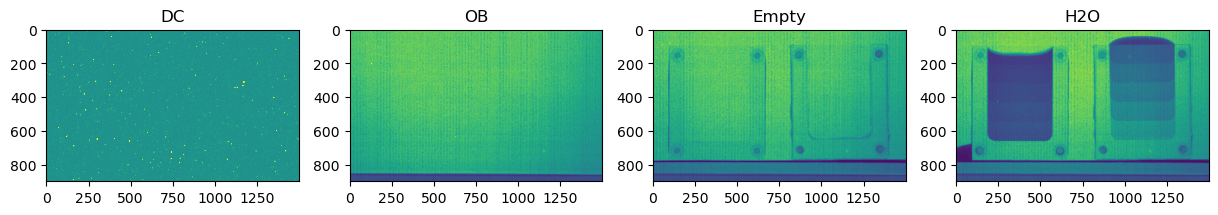

In [9]:
## Solution
dc    = tiff.imread('../00_common/data/stepwedge/exp60s_dc.tif')
ob    = tiff.imread('../00_common/data/stepwedge/exp60s_ob.tif')
empty = tiff.imread('../00_common/data/stepwedge/exp60s_empty.tif')
h2o   = tiff.imread('../00_common/data/stepwedge/exp60s_h2o.tif')

fig, ax = plt.subplots(1,4,figsize=(15,5))

ax[0].imshow(dc,vmin=200,vmax=400)
ax[0].set_title('DC')
ax[1].imshow(ob,vmin=300,vmax=20000)
ax[1].set_title('OB')
ax[2].imshow(empty,vmin=300,vmax=20000)
ax[2].set_title('Empty')
ax[3].imshow(h2o,vmin=300,vmax=20000)
ax[3].set_title('H2O');


Ideally, you should be able to calculate
$$p=\int_L \mu(x)dx= -log\left(\frac{I}{I_0}\right)$$
Technically, there are two details to handle when you want to normalize your images
1. The detector adds a bias to the images due to the dark current noise.
2. The neutron source is not operating with constant flux

<img src="figures/hipa-info.png" style="height:200px"/>

Therefore, we have to modify the equation to 
$$p=\int_L \mu(x)dx= -log\left(\frac{I-I_{DC}}{I_0-I_{DC}}\cdot \frac{D(I_0-I_{DC})}{D(I-I_{DC})}\right)$$
where $I_0$ is a dark current image and $D(\cdot)$ is a dose operator. The dose is often measured as the average gray level in a region on the side of the measured object. To do this you have to identify the coordinates of the region you like to use and use array slicing and the average operation, e.g. ```img[100:150, 200:250].mean()``` will compute the average value in the region of rows 100 to 150 and columns 200 to 250. The logarithm function is provided by numpy as ```np.log()```.

In [10]:
# Normalize (your code)


Subtract DC and adjust pixels less than '1' to '1'.

In [11]:
## Solution
empty = empty - dc
empty[empty<1]=1
h2o = h2o - dc
h2o[h2o<1]=1

Locate a region to compute the dose

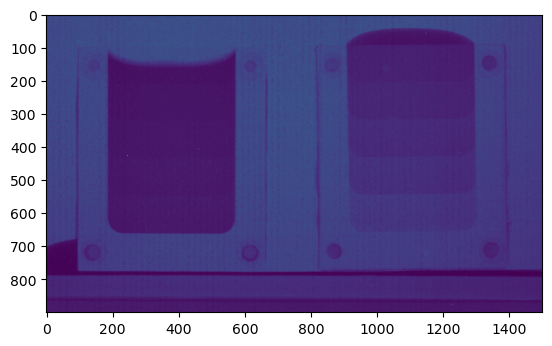

In [12]:
# Solution 
plt.imshow(h2o)
#plt.imshow(h2o[200:300,720:750])

# doses
d  = h2o[200:300,720:750].mean()
d0 = empty[200:300,720:750].mean()

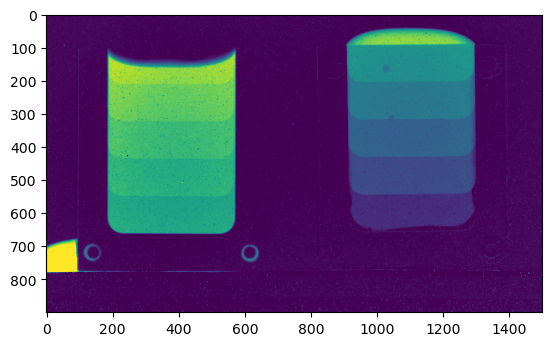

In [13]:
# solution continued
p=-np.log(d0/d*h2o/empty)
plt.imshow(p,vmin=0, vmax=1.75)

You can also compare the effect of including the dose term. Note that $p$ should be zero in air.

#### Obtain the step values from the images
The goal of the exercise is to obtain a gray value from each thickness in the wedges. This is again done using array slicing and averaging like for the dose value. This time, we will however only compute the average in one direction at first using ```img[100:150, 200:250].mean(axis=1)```. Here, ```axis=1``` tells that the average is computed in the horizontal direction only. Find the region you want to measure and plot the resulting average profile. You can also compute the standard deviation using the array method ```.std(axis=1)``` if you like. Fitting the data points to estimate the is easiest done using ```m,b=np.polyfit(x,y,1)```.

In [14]:
# Your fitting code


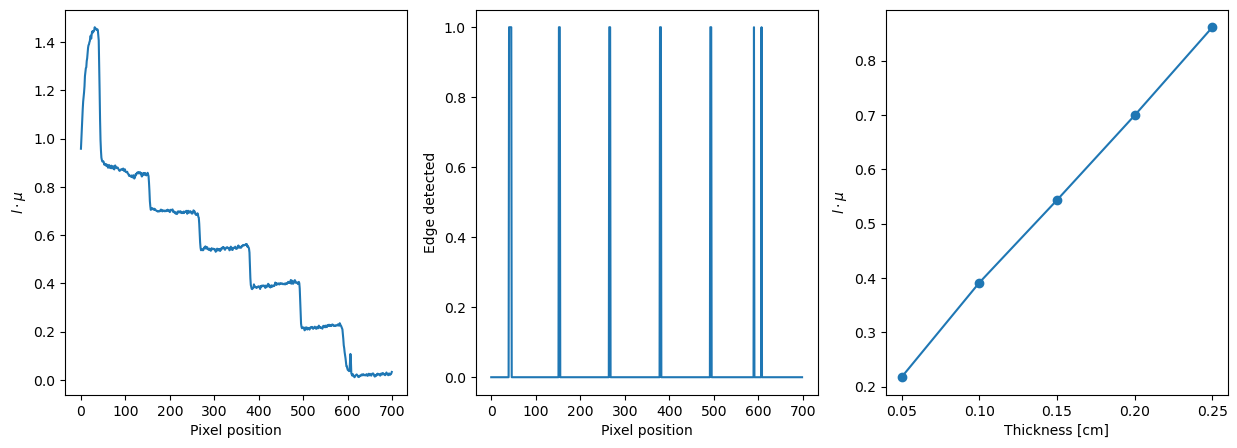

In [15]:
# solution
profile = p[50:750,1000:1200].mean(axis=1)
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(profile)
ax[0].set_xlabel(r'Pixel position')
ax[0].set_ylabel(r'$l\cdot{}\mu$')

# The steps are detected with help of a basic edge detection                 
ax[1].plot(np.diff(profile)<-0.025)
ax[1].set_xlabel(r'Pixel position')
ax[1].set_ylabel(r'Edge detected')                
                 
thickness = np.array([2.5,2,1.5,1,0.5])/10 # cm

ot0 = []

ot0.append(profile[80:120].mean())
ot0.append(profile[180:220].mean())
ot0.append(profile[290:350].mean())
ot0.append(profile[390:460].mean())
ot0.append(profile[500:560].mean())
ax[2].plot(thickness,ot0,marker='o')
ax[2].set_xlabel('Thickness [cm]')
ax[2].set_ylabel(r'$l\cdot{}\mu$');

__Comment:__ There are different ways to obtain the data points for this study. The trivial solution is to look up the index intervals manually. If you want a more challenging task, you can implement an automated solution using the ```label``` function from scikit image.

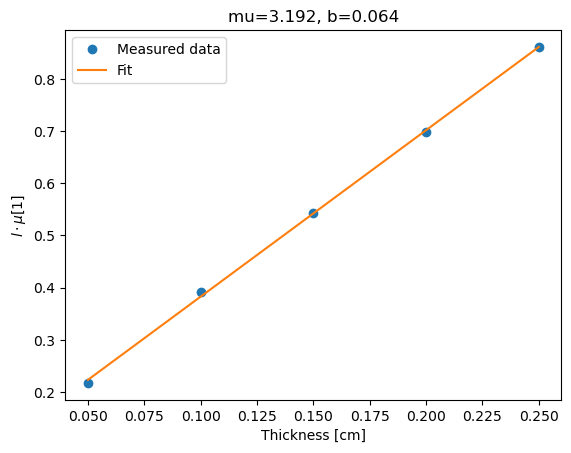

In [16]:
# solution continued
mu0, b0 = np.polyfit(thickness, ot0, 1)

plt.plot(thickness,ot0,'o', label = 'Measured data')
plt.plot(thickness,thickness*mu0+b0, label = 'Fit')
plt.title(r"mu={0:0.3f}, b={1:0.3f}".format(mu0,b0));
plt.xlabel('Thickness [cm]')
plt.ylabel(r'$l\cdot{}\mu{} [1]$');
plt.legend();

### The impact of scattering
The attenuation law assumes the radiation to be absorbed by the medium the are entering. This is however not true for neutrons. They are dominantly scattered in the material with the consequence that they will produce a bias in the images. This bias can result in measurement errors up to 50%. In the figure below, you can see how the ratio between scattering and absorption in by different commonly used elements.

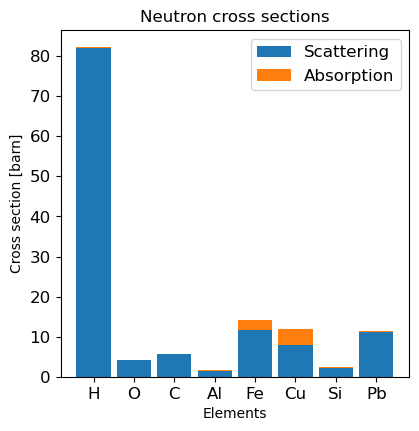

In [17]:
elements = 'H','O','C','Al','Fe','Cu','Si','Pb'
idx = np.arange(len(elements))
xs = np.array([[1.7568, 80.26,  82.02,  0.3326 ],
      [4.232,  0.0008, 4.232,  0.00019],
      [5.551,  0.001,  5.551,  0.0035],
      [1.495,  0.0082, 1.503,  0.231 ],
      [11.22,  0.4,    11.62,  2.56 ],
      [7.485,  0.55,   8.03,   3.78 ],
      [2.163,  0.004,  2.1670, 0.171],
      [11.115, 0.003,  11.118, 0.171 ]])

width= 0.85
fontsize=12
plt.figure(figsize=[4.5,4.5])
plt.bar(idx,xs[:,2],width,label='Scattering')
plt.bar(idx,xs[:,3],width,label='Absorption',bottom=xs[:,2])
plt.xticks(idx,elements,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xlabel('Elements')
plt.ylabel('Cross section [barn]')
plt.title('Neutron cross sections');

### Computing the attenuation coefficient - part 2

Correcting for the biases introduced by scattering requires additional reference images that allows you to estimate the scattering contributions from sample and instrument background. This is done by inserting a grid of absorbing dots. Ideally, there shouldn't be any intensity to measure behind these dots, in practice, however, there is. This intensity is caused by the scattered neutrons, and therefore, also the bias we want to subtract from the images to obtain a more correct normalization.
<img src="figures/scattering.jpeg" style="height:300px" />
[Boillat et al. 2018](https://doi.org/10.1364/OE.26.015769)

### Video - Explaining the black body grid
<video controls src="movies/ScatterCorrectionGrids.mp4" height="300px" type="video/mp4"></video>

[On youtube](https://youtu.be/9lPP-PrJx7U)

Scattering correction requires a revised form of the normalization equation we previously used. This equation now includes estimated of the scattered neutrons. These esitmates are computed from two additional reference images where a grid with black body dots is inserted in open beam and sample images. 
 
$$\frac{\tilde{I}_n}{\tilde{I}_{OB}}=\frac{I_n}{I_{OB}}\cdot\frac{D(I_{OB})}{D(I_{n})}=\frac{I_{n}^{*}-I_{DC}-I_{n,BB}^{S}\frac{D\left(I_{n}^{*}-I_{DC}\right)}{D\left(I_{n,BB}^{*}-I_{DC}-\left(1-\frac{1}{\tau_{BB}}\right)I_{n,BB}^{S}\right)\tau_{BB}}}{I_{OB}^{*}-I_{DC}-I_{BG,BB}^{S}\frac{D\left(I_{OB}^{*}-I_{DC}\right)}{D\left(I_{OB,BB}^{*}-I_{DC}-\left(1-\frac{1}{\tau_{BB}}\right)I_{BG,BB}^{S}\right)\tau_{BB}}}\cdot\frac{D\left(I_{OB}^{*}-I_{DC}-I_{BG,BB}^{S}\frac{D\left(I_{OB}^{*}-I_{DC}\right)}{D\left(I_{OB,BB}^{*}-I_{DC}-\left(1-\frac{1}{\tau_{BB}}\right)I_{BG,BB}^{S}\right)\tau_{BB}}\right)}{D\left(I_{n}^{*}-I_{DC}-I_{n,BB}^{S}\frac{D\left(I_{n}^{*}-I_{DC}\right)}{D\left(I_{n,BB}^{*}-I_{DC}-\left(1-\frac{1}{\tau_{BB}}\right)I_{n,BB}^{S}\right)\tau_{BB}}\right)}$$

The revised equation is, as you can see, quite complicated and __we will use a pre-implemented function__ in this exercise.

In this exercise we'll need some additional reference images. Namely those needed to estimate the bias introduced by scattering. These images are also located in the folder with the step wedge images.

- ```exp##s_bbempty.tif```
- ```exp##s_bbh2o.tif```

In [ ]:
# Load and show BB images (your code). 

bbob  = 
bbs   = 

# Also load all the other images to clean up the scene
dc    = 
ob    = 
empty = 
h2o   = 

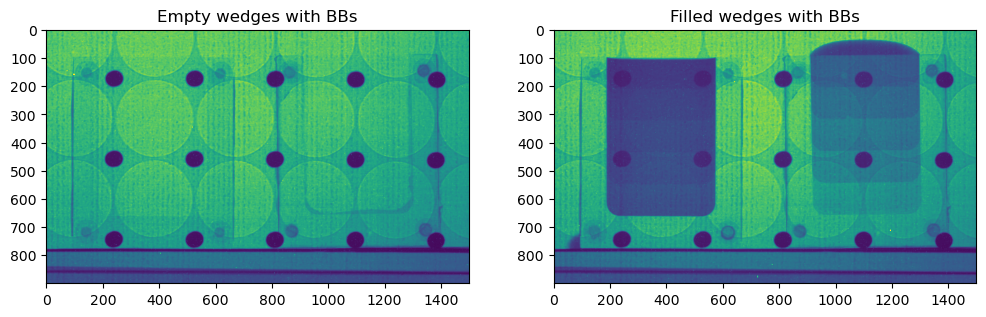

In [18]:
# Solution
bbob  = tiff.imread('../00_common/data/stepwedge/exp60s_bbempty.tif')
bbs   = tiff.imread('../00_common/data/stepwedge/exp60s_bbh2o.tif')
dc    = tiff.imread('../00_common/data/stepwedge/exp60s_dc.tif')
ob    = tiff.imread('../00_common/data/stepwedge/exp60s_ob.tif')
empty = tiff.imread('../00_common/data/stepwedge/exp60s_empty.tif')
h2o   = tiff.imread('../00_common/data/stepwedge/exp60s_h2o.tif')

fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].imshow(bbob,vmin=300,vmax=20000)
ax[0].set_title('Empty wedges with BBs')

ax[1].imshow(bbs,vmin=300,vmax=20000)
ax[1].set_title('Filled wedges with BBs');

We now want to fit the shape of the graylevels behind the black body dots. This is done in two steps:
1. Detect the dots
2. Fit the dot information to a second order polynomial in x and y.

The dot detection is based on a method called template matching. The method requires a template of what it is supposed to find. In our case this is an isolated black body dot. The dot is located in the ROI described by the parameter ```roi=[r0,c0,r1,c1]```

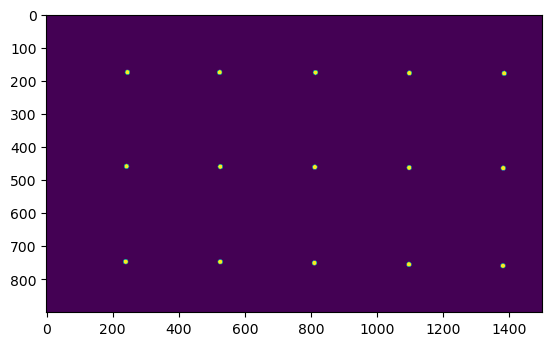

In [19]:
# Load the bbmask
bbmask = tiff.imread('../00_common/data/stepwedge/bb_masked.tif')
bbmask=morph.erosion(bbmask,morph.disk(3))
plt.imshow(bbmask);

The next step is to measure the graylevels behind the BB dots

In [20]:
# Support function to extract the bb info
from skimage.measure import label, regionprops
from skimage.draw import disk
def get_bb_info(img,mask,R) :
    lbl = label(bbmask)
    regions=[]
    for region in regionprops(lbl):
        x,y = region.centroid
        rr, cc = disk((x,y), R) 
        dotdata = img[rr,cc]
        regions.append({'label': region.label,
                        'mean' : np.mean(dotdata),
                        'median' : np.median(dotdata),
                        'r' : region.centroid[0],
                        'c' : region.centroid[1]})
        
    return pd.DataFrame.from_dict(regions)

In [21]:
rbbs  = get_bb_info(bbs,bbmask,R=5)
rbbob = get_bb_info(bbob,bbmask,R=5)

rbbs.head()

,label,mean,median,r,c
0,1,2282.620253,2234.0,175.540881,245.893082
1,2,2296.543210,2269.0,175.662577,524.638037
2,3,2389.594937,2220.0,176.175000,814.581250
3,4,2574.518987,2496.0,177.807453,1098.459627
4,5,1736.708861,1704.0,178.706250,1385.293750


Now, we are ready to create images with the scattering contribution for open beam and sample image. We will be using the median gray level here to reduce the impact of outliers.

In [22]:
bbs_s  = bb.compute_scatter_image_from_df(rbbs,bbs.shape,info='median');

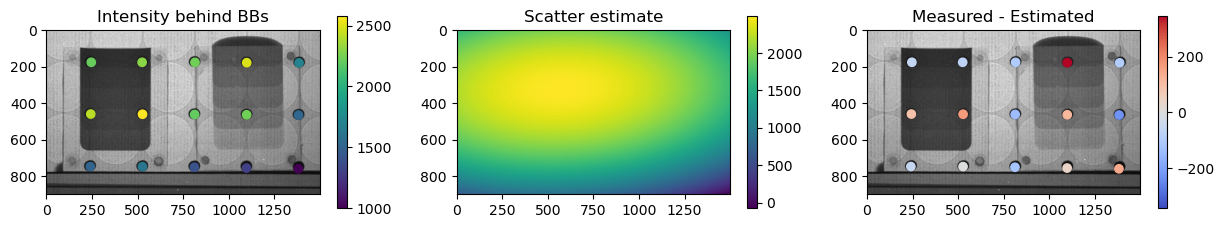

In [23]:
# Visualization
cmap = 'coolwarm'
fig,ax=plt.subplots(1,3,figsize=(15,5))
df=bb.check_scatter_image(bbs,0,bbmask,ax=ax[0],cmap='viridis',clim=[0,20000])
ax[0].set_title('Intensity behind BBs')
a1=ax[1].imshow(bbs_s,cmap='viridis')
ax[1].set_title('Scatter estimate')
fig.colorbar(a1,ax=ax[1],shrink=0.5)
df=bb.check_scatter_image(bbs,bbs_s,bbmask,ax=ax[2],cmap=cmap,sym_cmap=True,clim=[0,20000])
ax[2].set_title('Measured - Estimated');

In [24]:
bbob_s = bb.compute_scatter_image_from_df(rbbob,bbob.shape,info='median');

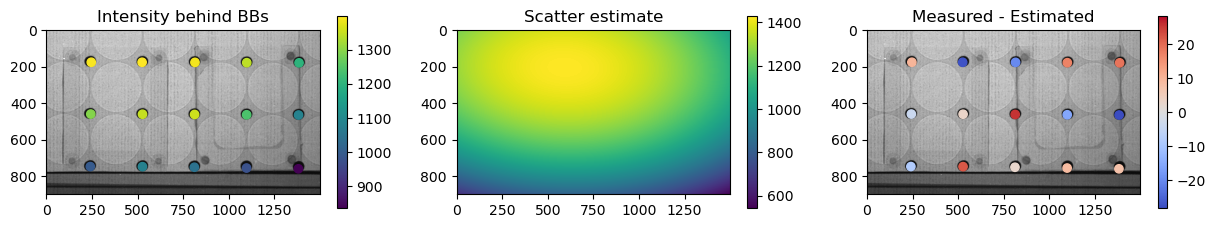

In [25]:
# Visualization
cmap = 'coolwarm'
fig,ax=plt.subplots(1,3,figsize=(15,5))
df=bb.check_scatter_image(bbob,0,bbmask,ax=ax[0],cmap='viridis',clim=[0,20000])
ax[0].set_title('Intensity behind BBs')

a1=ax[1].imshow(bbob_s,cmap='viridis')
ax[1].set_title('Scatter estimate')
fig.colorbar(a1,ax=ax[1],shrink=0.5)

df=bb.check_scatter_image(bbob,bbob_s,bbmask,ax=ax[2],cmap=cmap,sym_cmap=True,clim=[0,20000])
ax[2].set_title('Measured - Estimated');

The last step of this extended normalization procedure is to apply the equation above. Here, it is importand to mark a roi for the dose correction. This should be a region outside the samples and the grid as well.

/var/folders/hj/l3z3z7bj663f4wp4vlx69lt40000nw/T/ipykernel_73259/60941127.py:1: RuntimeWarning: invalid value encountered in log
  nimg_sc   = -np.log(bb.normalization_with_BB(h2o,empty,dc,bbs,bbob,bbs_s,bbob_s,[0,600,50,700],0.97))


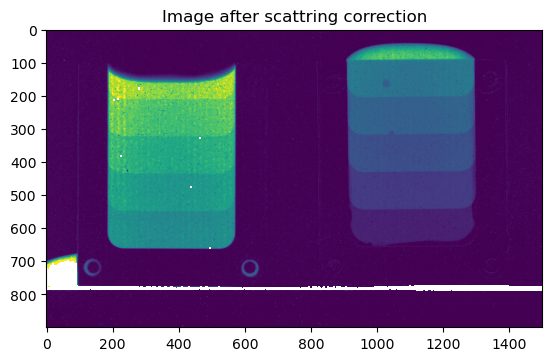

In [26]:
nimg_sc   = -np.log(bb.normalization_with_BB(h2o,empty,dc,bbs,bbob,bbs_s,bbob_s,[0,600,50,700],0.97))
plt.imshow(nimg_sc,vmin=0,vmax=3);
plt.title('Image after scattring correction');

At last we can inspect what the profile looks like. Before and after scattering correction. Again plot the profile over the step wedge using the two images from before and after. The white spots can be removed using a spot cleaning filter or plainly apply a median filter like ```skimage.filters.median```. The white line and blob below the step wedges are too opaque for the neutrons to be transmitted.

In [27]:
# your code for the plotting


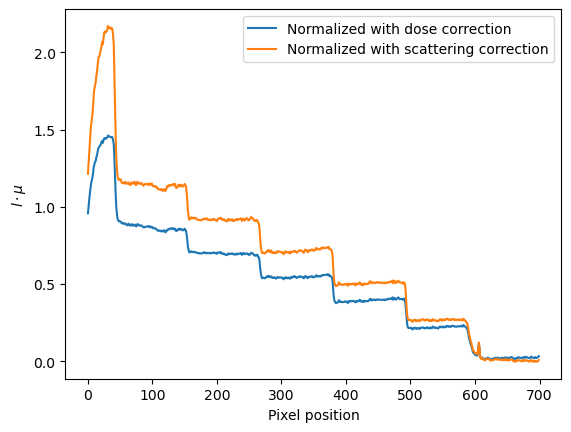

In [28]:
# Solution
p0 = p[50:750,1000:1200].mean(axis=1)
p1 = nimg_sc[50:750,1000:1200].mean(axis=1)

plt.plot(p0,label='Normalized with dose correction')
plt.plot(p1,label='Normalized with scattering correction')
plt.xlabel(r'Pixel position')
plt.ylabel(r'$l\cdot{}\mu$')
plt.legend();

Repeat the fitting steps to obtain the new attenuation coefficient for water now that we have the scatter corrected image. Compare the results with the uncorrected case.

In [29]:
# Your code to fit the new data and compare the result to the first fit


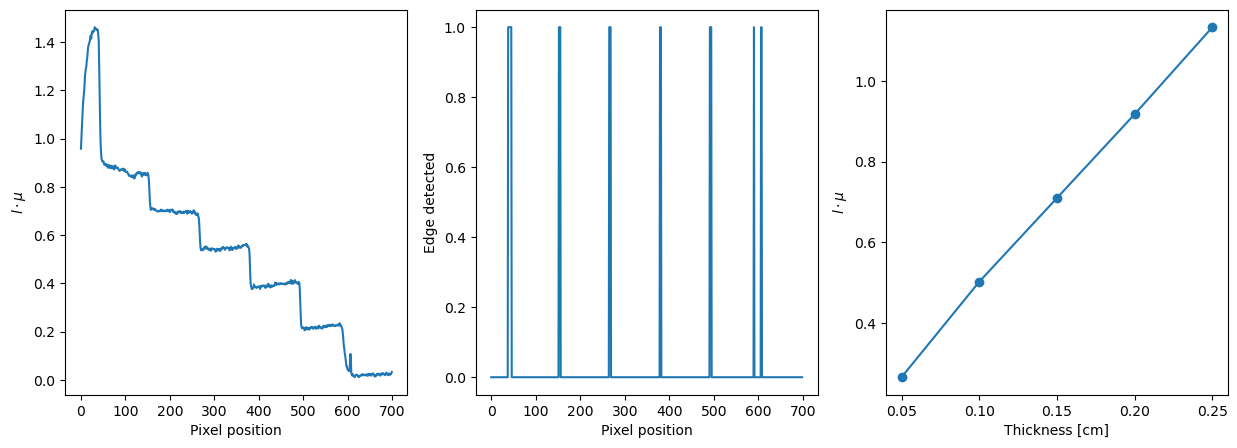

In [30]:
# solution
profile = p[50:750,1000:1200].mean(axis=1)
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(profile)
ax[0].set_xlabel(r'Pixel position')
ax[0].set_ylabel(r'$l\cdot{}\mu$')

# The steps are detected with help of a basic edge detection                 
ax[1].plot(np.diff(p1)<-0.025)
ax[1].set_xlabel(r'Pixel position')
ax[1].set_ylabel(r'Edge detected')                
                 
thickness = np.array([2.5,2,1.5,1,0.5])/10 # cm

ot1 = []

ot1.append(p1[80:120].mean())
ot1.append(p1[180:220].mean())
ot1.append(p1[290:350].mean())
ot1.append(p1[390:460].mean())
ot1.append(p1[500:560].mean())
ax[2].plot(thickness,ot1,marker='o')
ax[2].set_xlabel('Thickness [cm]')
ax[2].set_ylabel(r'$l\cdot{}\mu$');

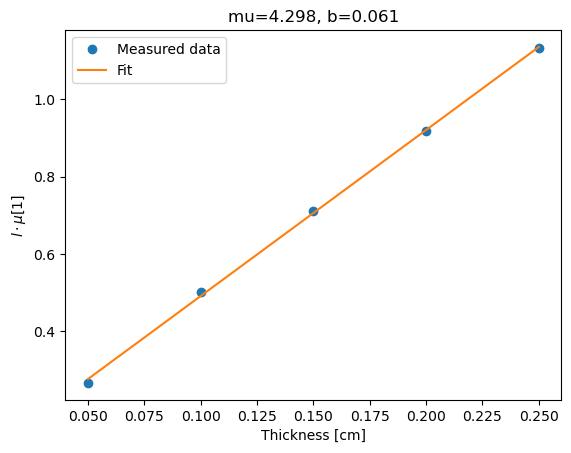

In [31]:
# solution continued
mu1, b1 = np.polyfit(thickness, ot1, 1)

plt.plot(thickness,ot1,'o', label = 'Measured data')
plt.plot(thickness,thickness*mu1+b1, label = 'Fit')
plt.title(r"mu={0:0.3f}, b={1:0.3f}".format(mu1,b1));
plt.xlabel('Thickness [cm]')
plt.ylabel(r'$l\cdot{}\mu{} [1]$');
plt.legend();


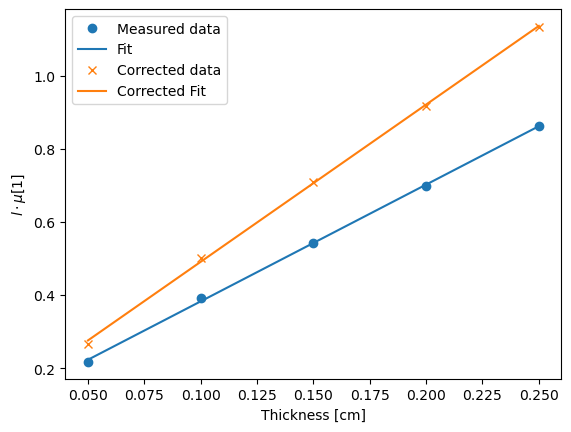

In [32]:
# solution continued
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(thickness,ot0,'o',c=cycle[0], label = 'Measured data')
plt.plot(thickness,thickness*mu0+b0,c=cycle[0], label = 'Fit')
plt.plot(thickness,ot1,'x',c=cycle[1], label = 'Corrected data')
plt.plot(thickness,thickness*mu1+b1, c=cycle[1],label = 'Corrected Fit')
plt.xlabel('Thickness [cm]')
plt.ylabel(r'$l\cdot{}\mu{} [1]$');
plt.legend();

This exercise shows the importance of a correction procedure to handle the scattering from sample and the background in the instrument.

## Summary

In this tutorial, we learned how quantify information from neutron images.

1. We measured the attenuation coefficient of water 
2. saw the impact of scattered neutrons. 
3. The attenuation coefficient is used to measure the amount of water in a sample based on variations in gray levels. It is therefore important to know this constant very precisely.


In addition to learning more about these main objectives, we also learned how to use different python packages to solve the analysis tasks in a repeatable way and also how to present the results in plots and image displays.